# LSTM

## 영화리뷰 감성(긍정/부정) 분석

In [30]:
# 자료 링크 : https://github.com/e9t/nsmc

In [31]:
# pip install pandas matplotlib tensorflow scikit-learn
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler # 정규화
from sklearn.feature_extraction.text import TfidfVectorizer # 벡터화

In [32]:
# 폰트지정 
plt.rcParams['font.family'] = 'Apple Gothic' # macOS용
# 마이너스 부호 깨짐 지정
plt.rcParams['axes.unicode_minus'] = False
# 숫자가 지수표현식으로 나올 때 지정
pd.options.display.float_format = '{:.2f}'.format

In [33]:
# 1. 데이터 로드 
# 데이터 로드
train_df = pd.read_csv("dataset/ratings_train.txt", sep='\t', encoding='utf-8') # 훈련용 데이터셋
# cp949 대신 utf-8 사용
test_df = pd.read_csv("dataset/ratings_test.txt", sep='\t', encoding='utf-8 ') # 테스트용 데이터셋

In [34]:
# 데이터 열과 행 확인(데이터수)
train_df.shape # 훈련용 데이터

(150000, 3)

In [35]:
# 데이터 열과 행 확인(데이터수)
test_df.shape # 테스트용 데이터

(50000, 3)

In [36]:
# 샘플 데이터 확인
train_df.head()# 학습용 데이터

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [37]:
# 샘플 데이터 확인
test_df.head()# 테스트용 데이터

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [38]:
# 결측치 제거 : 누락된 데이터(결측치) 완전 제거된 상태로 저장
train_df = train_df.dropna() 
test_df = test_df.dropna()

In [39]:
# 결측치 확인
print("학습용 데이터 결측치 확인:")
print(train_df.isnull().sum())
print("\n테스트용 데이터 결측치 확인:")
print(test_df.isnull().sum())

학습용 데이터 결측치 확인:
id          0
document    0
label       0
dtype: int64

테스트용 데이터 결측치 확인:
id          0
document    0
label       0
dtype: int64


In [40]:
# 2. 전처리
# TF-IDF 벡터화 : 단어의 빈도수
vectorizer = TfidfVectorizer(max_features=5000) # 가장 많이 등장하는 단어 5000개 선택
# 훈련용 데이터 : 문자를 숫자로 변환 (텍스트 벡터화)
X_train_tfidf = vectorizer.fit_transform(train_df['document']).toarray() 
# 테스트용 데이터 : 숫자(0,1)로만 테스트 => 과정 파악 
X_test_tfidf = vectorizer.transform(test_df['document']).toarray()  

In [41]:
# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1)) # 모든 값 0~1 범위로 지정
X_train_scaled = scaler.fit_transform(X_train_tfidf) # 문자를 숫자로 반환
X_test_scaled = scaler.transform(X_test_tfidf) # 숫자로만 테스트

In [42]:
# LSTM 입력 형태(3D 텐서)로 변환
# 시계열 데이터 형식으로 변환 (3D 텐서): samples, timesteps, features
time_step = 1  # 한번에 한문장씩 처리
# 훈련용 데이터
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], time_step, X_train_scaled.shape[1]) 
# 테스트용 데이터
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], time_step, X_test_scaled.shape[1])

In [43]:
# 레이블 : 정답 데이터 
y_train = train_df['label'].values # 훈련용 데이터
y_test = test_df['label'].values # 테스트용 데이터

In [44]:
# 3. LSTM 모델 구성
model = Sequential() 
# 첫번째 LSTM 레이어
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, 
                input_shape=(time_step, X_train_reshaped.shape[2])))
# 두번째 LSTM 레이어
model.add(LSTM(32))
model.add(Dense(16, activation='relu')) # 완전 연결 레이어
# 마지막 LSTM 레이어
model.add(Dropout(0.2)) # 과적합 방지
model.add(Dense(1, activation='sigmoid')) # 최종 이진분류 선택

/Users/hwangseoyeong/Documents/ai/project/dlproject/movielstm/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [45]:
# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# 알고리즘 : adma 옵티마이저, loss : 이진 분류
model.summary() # 모델의 구조(레이어, 파라미터 개수, 출력 형태 등) 출력

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 1, 64)          │     1,296,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,309,601 (5.00 MB)

 Trainable params: 1,309,601 (5.00 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# 4. 모델 학습
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3), # 검증 손실로 3번 연속 증가시 학습 중단
    ModelCheckpoint('model/movie_best_model.h5', monitor='val_accuracy', save_best_only=True)
    # 모델로 데이터 저장    
]

history = model.fit(
    X_train_reshaped, y_train, # 입력 데이터와 정답
    epochs=10, # 전체 학습 반복 횟수
    batch_size=64, # 학습할 샘플 데이터 갯수
    validation_split=0.2, # 훈련용 데이터 20%
    callbacks=callbacks, # 조기 종료 및 최적 모델 저장 콜백 함수
    verbose=1  # 훈련 진행상황 출력
)    

Epoch 1/10
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6825 - loss: 0.5512

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.6827 - loss: 0.5511 - val_accuracy: 0.7778 - val_loss: 0.4320
Epoch 2/10
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7618 - loss: 0.4547

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.7618 - loss: 0.4547 - val_accuracy: 0.7795 - val_loss: 0.4267
Epoch 3/10
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7737 - loss: 0.4343

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.7737 - loss: 0.4343 - val_accuracy: 0.7802 - val_loss: 0.4240
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.7856 - loss: 0.4152 - val_accuracy: 0.7796 - val_loss: 0.4269
Epoch 5/10
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7860 - loss: 0.4089

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.7860 - loss: 0.4089 - val_accuracy: 0.7806 - val_loss: 0.4247
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7892 - loss: 0.4029 - val_accuracy: 0.7791 - val_loss: 0.4274


In [47]:
# 학습이 몇 번째 에폭에서 멈췄는지 확인
actual_epochs = len(history.history['loss'])
print(f"학습이 {actual_epochs}번째 에폭에서 완료되었습니다.")

학습이 6번째 에폭에서 완료되었습니다.


In [48]:
# 5. 모델 평가 : 모델 데이터에서 얼마나 정확힌지 측정
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print(f'테스트 정확도: {accuracy:.4f}')

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7767 - loss: 0.4318
테스트 정확도: 0.7752


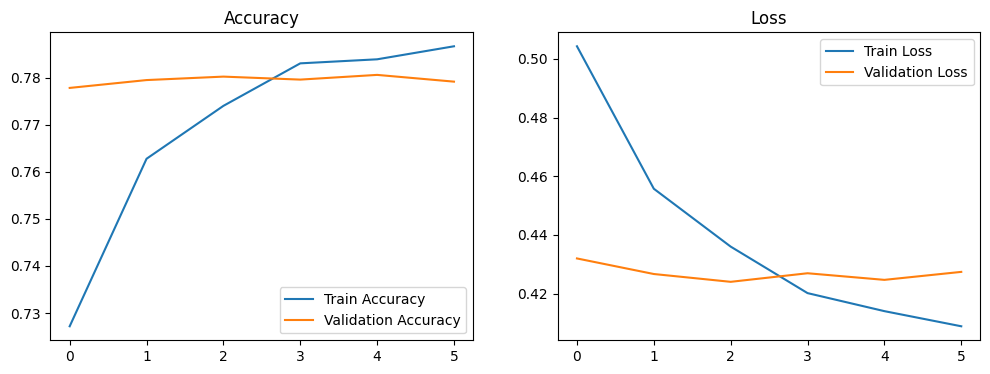

In [49]:
# 6. 결과 시각화
# 학습 곡선 시각화 
# Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')  
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss') # 손실 함수 
plt.legend()


# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy') 
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy') # 정확도
plt.legend()
plt.show()

In [50]:
# 7. 감성 예측 함수
def predict_sentiment(text):
    # 벡터화
    vector = vectorizer.transform([text]).toarray()
    # 정규화
    scaled = scaler.transform(vector)
    # 시계열 데이터 형식으로 변환
    reshaped = scaled.reshape(1, time_step, scaled.shape[1])
    # 예측
    score = model.predict(reshaped)[0][0]
    return "긍정" if score > 0.5 else "부정", score # 0: 부정, 1: 긍정

In [51]:
# 테스트
sample_reviews = [
    "꿀잼! 또 보고 싶다..",
    "직장인으로써 완전 공감...",
    "사짱님 잘 생겼다.. 저도 고용해주세요.",
    "완전 노잼.. 돈버림ㅠㅠ,..,,"
]

for review in sample_reviews:
    sentiment, score = predict_sentiment(review)
    print(f"리뷰: {review}")
    print(f"감성: {sentiment} (점수: {score:.4f})")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
리뷰: 꿀잼! 또 보고 싶다..
감성: 긍정 (점수: 0.9800)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
리뷰: 직장인으로써 완전 공감...
감성: 긍정 (점수: 0.7239)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
리뷰: 사짱님 잘 생겼다.. 저도 고용해주세요.
감성: 긍정 (점수: 0.7462)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
리뷰: 완전 노잼.. 돈버림ㅠㅠ,..,,
감성: 부정 (점수: 0.0096)
--------------------------------------------------


In [52]:
from ydata_profiling import ProfileReport
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 폰트지정 
import matplotlib.font_manager as fm

# fm.fontManager.addfont('/System/Library/Fonts/Supplemental/AppleGothic.ttf') # 상대 경로로 추가
# plt.rcParams['font.sans-serif'] = ['AppleGothic']

# 폰트지정 
plt.rcParams['font.family'] = 'AppleGothic' # macOS용
# 마이너스 부호 깨짐 지정
plt.rcParams['axes.unicode_minus'] = False
# 숫자가 지수표현식으로 나올 때 지정
pd.options.display.float_format = '{:.2f}'.format


# 데이터 로드
train_df = pd.read_csv("dataset/ratings_train.txt", sep='\t', encoding='utf-8') # 훈련용 데이터셋

# 프로파일링 보고서 생성
profile = ProfileReport(train_df, title="Movie Dataset Profiling Report", explorative=True)

# info() 출력
print(profile.to_html())  # HTML로 출력하여 확인

# 보고서 저장 (HTML 파일)
output_file = 'report/train_data_EDA_report.html'
profile.to_file(output_file)
print(f"프로파일링 보고서가 생성되었습니다: {output_file}") # find에서 파일 열어보기

Render HTML: 100%|██████████| 1/1 [00:00<00:00, 20.77it/s]


<!doctype html><html lang=en><head><meta charset=utf-8><meta name=viewport content="width=device-width, initial-scale=1, shrink-to-fit=no"><meta name=description content="Profile report generated by YData! Visit us at https://ydata.ai"><meta name=author content="YData and the open source community."><meta name=generator content="YData Profiling vv4.16.1"><meta name=url content=https://github.com/ydataai/ydata-profiling><meta name=date content="2025-05-06 05:31:55.008292"><title>Movie Dataset Profiling Report</title><style>
@charset "UTF-8";/*!
 * Bootstrap  v5.3.3 (https://getbootstrap.com/)
 * Copyright 2011-2024 The Bootstrap Authors
 * Licensed under MIT (https://github.com/twbs/bootstrap/blob/main/LICENSE)
 */:root,[data-bs-theme=light]{--bs-blue:#0d6efd;--bs-indigo:#6610f2;--bs-purple:#6f42c1;--bs-pink:#d63384;--bs-red:#dc3545;--bs-orange:#fd7e14;--bs-yellow:#ffc107;--bs-green:#198754;--bs-teal:#20c997;--bs-cyan:#0dcaf0;--bs-black:#000;--bs-white:#fff;--bs-gray:#6c757d;--bs-gray-d

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 537.94it/s]

프로파일링 보고서가 생성되었습니다: report/train_data_EDA_report.html
